<a href="https://colab.research.google.com/github/laiadc/DL-schrodinger/blob/main/Coupled_morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/laiadc/DL-schrodinger.git

Cloning into 'DL-schrodinger'...
remote: Enumerating objects: 304, done.
remote: Total 304 (delta 0), reused 0 (delta 0), pack-reused 304
Receiving objects: 100% (304/304), 961.48 MiB | 39.06 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (132/132), done.


In [2]:
cd DL-schrodinger

/content/DL-schrodinger


In [3]:
%tensorflow_version 2.x

# Integrating the Schrödinger equation with Deep Learning in 2D

This notebook extends the work developed in *Random potentials1D.ipynb* by using two-dimensional potentials. In this case, we will train a neural network to  find the stationary states of the Time-Independent Schrödinger equation in 2D:

$$
\Big( - \frac{\hbar^2}{2m} (\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}) + V(x,y) \Big) \phi_n(x,y) = E_n \phi_n(x,y) 
$$

Where $\hbar$ is the reduced Plank constant, $m$ is the mass of the particle, $V(x,y)$ is the potential under which the particle evolves. $\phi_n(x,y)$ is the $n$-th stationary state of the quantum system, with energy $E_n$. The subscrit $n$ can be discrete ($n \in \mathbb{Z}$) or continuous ($n \in \mathbb{R}$).

The stationary wave functions $\phi_n(x,y)$ have a trivial time evolution:

$$
\phi_n(x,y,t) = \phi_n(x,y) e^{-i \frac{E_n}{\hbar}t}
$$

They form a basis of the Hilbert Space of the Hamiltonian of the system

$$
\hat{H} = \frac{\hat{p}^2}{2m} + V(\hat{x,y})
$$

Therefore, the evolution of an arbitrary state of the system $\psi(x,t)$ will be given by:

$$
\psi(x,y,t) = \sum_k c_k \phi_k(x,y) e^{-i \frac{E_k}{\hbar}t} 
$$

Where $c_k$ are linear coefficients and the sum over $k$ can be either discrete or continuous (an integral). The modulus square of the coefficients $|c_k|^2$ represents the probability of being in the $k$-th excited state. 



In [5]:
#@title Class to find eigenstates using the H.O basis
#@markdown Double click to see the code
import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema

class eigen_state_potential2D_omega:

  def __init__(self, alpha_min=None, alpha_max=None, N=10, omega =1/np.sqrt(2) ):
    '''
    Class to generate data (V(x) and phi(x) ground state) for potentials of the form
    V(x) = sum_i alpha_i x^i, using the H.O basis
    Args:
      alpha_min: vector of length N, with the minimum value of the coefficients alpha
      alpha_max: vector of length N, with the maximum value of the coefficients alpha
                 the values of alpha will be randomly distributed in [alpha_min, alpha_max]
      N (int): size of HO basis
      omega (float): omega of the HO basis
      k (int): Number of alphas for V(x)
      nxs (np.array): Order of nx
      nys (np.array): Order of ny
    '''
    if len(alpha_min)!=len(alpha_max):
      print("Error. Inconsisten shapes")
    self.alpha_min = np.array(alpha_min)
    self.alpha_max = np.array(alpha_max)
    self.N = N # Length of H.O basis
    self.k = len(alpha_min) #Number of alphas for V(x)
    self.omega = omega
    nxs, nys = self.order_energy(N, 1.0, self.omega)
    self.nxs = nxs
    self.nys = nys

  def order_energy(self,n_state, omegax, omegay):
      """
      Given omegax, omegay, we find the n_state-th excited state
      Args:
        n_state (int): Number of excited state
        omegax (float): omega in the x direction
        omegay (float): omega in the y direction
      Returns:
        (int) nx of the n_state excited state
        (int) ny of the n_state excited state
      """

      # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
      # Up to n_state (so nx,ny<= n_state), and then we order them by energy
      nxs = np.zeros((n_state+1)**2)
      nys = np.zeros((n_state+1)**2)
      Es = np.zeros((n_state+1)**2)
      i=0
      for nx in range(n_state+1):
        for ny in range(n_state+1): 
            nxs[i] = nx
            nys[i] = ny
            Es[i] = (omegax*(nx+1/2) + omegay*(ny + 1/2))
            i+=1
      
      idxs = np.argsort(Es)
      nxs = nxs[idxs]
      nys = nys[idxs]
      return nxs, nys


  def I_nmr(self,n,m,r):
    '''
    Calculates the value of the integral of the Hermitte polynomials
    Args:
      n (int): n of I(n,m,r)
      m (int): m of I(n,m,r)
      r (int): r of I(n,m,r)
    Returns:
      I(n,m,r)
    '''
    if r<0 or n<0 or m<0:
      return 0
    if r==0:
      if n==m:
        return np.sqrt(np.pi)*2**n*factorial(n)
      else:
        return 0
    return 1./2*self.I_nmr(n+1,m,r-1) + n*self.I_nmr(n-1,m,r-1)


  def int_P(self,n,m):
    '''
    Calculates the value of P(x|n,m)
    Args:
      n (int): n of I(n,m,r)
      m (int): m of I(n,m,r)
    Returns:
      P(x|n,m)
    '''
    I1 = -1/2*self.I_nmr(n,m,2)
    I2 = 1/2*self.I_nmr(n,m,0)
    I3 = 2*m*self.I_nmr(n,m-1,1)
    I4 = -2*m*(m-1)*self.I_nmr(n, m-2,0)
    return I1 + I2 + I3 + I4


  def C_nm(self,n,m, alphas):
    '''
    Calculates the coefficient C_{nm} for the potential V(x,y) = \sum_i \sum_j alpha[i,j]x^iy^j
    Args:
      n (int): n of C_nm
      m (int): m of C_nm
      alphas (np.array): size kxk. Coefficients of the potential V(x,y)
    Returns:
      C_{nm}
    '''
    # Given n and m find nx, ny, mx, my
    nx = self.nxs[n]
    ny = self.nys[n]
    mx = self.nxs[m]
    my = self.nys[m]

    # Find the normalization constants
    anx = np.sqrt(np.pi)*factorial(nx)*2**nx
    any = np.sqrt(np.pi)*factorial(ny)*2**ny
    amx = np.sqrt(np.pi)*factorial(mx)*2**mx
    amy = np.sqrt(np.pi)*factorial(my)*2**my
    A = 1./np.sqrt(anx*any*amx*amy)

    # Calculate integrals
    #Ix
    if ny==my:
      Ix = any*self.int_P(nx,mx)
    else:
      Ix = 0
    #Iy
    if nx==mx:
      Iy = self.omega*anx*self.int_P(ny,my)
    else:
      Iy = 0
    #Iv
    Iv = 0
    for i in range(alphas.shape[0]):
      for j in range(alphas.shape[1]):
        if alphas[i,j]>1e-6:
          Iv+=alphas[i,j]*1./np.sqrt(self.omega**j)*self.I_nmr(nx,mx,i)*self.I_nmr(ny,my,j)
    return A*(Ix+Iy+Iv)

  def find_eigen_state(self,alphas, n_state=0):
    '''
    Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
    Args:
      alphas(np array): size kxk. Coefficients of the potential V(x)
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E_a (float): Energy of the ground state for potential V
      a (np.array): size N. Coefficients in the basis of the H.O potential
      D (np.array): matrix D
      Hs (np.array): eigen energies
      C (np.array): matrix C
      veps (np.array): eigenfunctions
    '''
    N = self.N
    # 0. Generate matrix of C_nm
    C = np.zeros((N,N))
    for n in range(N):
      for m in range(N):
        C[n,m] = self.C_nm(n,m,alphas)

    # 1. Generate matrix D
    D = np.zeros((N,N))
    for n in range(N):
      for m in range(n+1):
        D[n,m] = C[n,m] + C[m,n]
        D[m,n] = D[n,m]

    # 2. Diagonalize matrix D
    vaps, veps = eigh(D)

    # 3. Calculate <H> for all a
    Hs = np.zeros(N)
    for i in range(N):
      a = veps[:, i]
      for n in range(N):
        for m in range(N):
          Hs[i]+=a[n]*a[m]*C[n,m]

    # 4. We choose the vector which minimizes <H>
    # If n_state!=0, we choose the vector with n_state-th lowest energy
    # as an approximation of the n_state excited state 
    idxs = np.argsort(Hs)
    sel = idxs[n_state]
    a = veps[:, sel] # Final value of eigenvalues for state n_state
    E_a = Hs[sel] # Value of the energy
    return E_a, a, D, Hs[idxs], C, veps[:,idxs]

  def generate_data(self,n_samples, alpha=np.array([None]), n_state=0, display=1):
    '''
    Generates samples of potentials  with random coefficients and finds the n_state excited state for them
    Args:
      n_samples (int): Number of samples of potentials (alphas)
      alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
      n_state (int): Number of excited state (default n_state=0, ground state)
      display (int): display step
    Returns:
      E (np.array): size n_samples. Ground energy for each V
      a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      alpha (np.array): size n_samples x k x k. Coefficients of the potentials V(x,y)
    '''
    data = np.zeros((n_samples, self.N))

    # Generate random value of alphas
    if (alpha==None).any():
      print("Random alphas")
      r_alpha = np.random.random((n_samples, self.k,self.k)) # Values between 0 and 1
      alpha = r_alpha*(self.alpha_max - self.alpha_min)+ self.alpha_min # random alpha
    
    # Prepare vectors of energies and coefficients
    E = np.zeros(n_samples)
    a = np.zeros((n_samples, self.N))
    veps = np.zeros((n_samples, self.N, self.N))
    # Find ground state for each sample
    for i in range(n_samples):
      if i%display==0:
        print("\rGenerating data: {}/{}".format(i,n_samples), end='')
      E_new, a_new,_,_,_,veps_new = self.find_eigen_state(alpha[i,:,:], n_state)
      E[i] = E_new
      a[i,:] = a_new
      veps[i] = veps_new
    return E, a, alpha, veps   

  def evaluate_potential(self,xmin, xmax,ymin, ymax, n_points, alpha):
    '''
    Given the coeefficients alphas, it evaluates the potential in V(x)
    Args:
      xmin(float): minimum value of x
      xmax (float): maximum value of x
      ymin(float): minimum value of y
      ymax (float): maximum value of y
      n_points (int): Number of points between xmin and xmax
      alpha (np.array): size n_samples x k x k. Matrix of coefficients of V(x) (each row a different potential)
    Returns:
      V(np.array): size n_samples x n_points x n_points. V(x) for every sample
      x(np.array): size n_points. Values of x and y
    '''
    x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    y = np.arange(ymin, ymax, (ymax - ymin)/n_points)
    n_samples, k,_ = alpha.shape
    V = np.zeros((n_samples, n_points, n_points))# V(x,y) in each row different alpha
    x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
    y_mat = (y**np.arange(k)[:,None])# Matrix of powers of y: y^0, y^1, y^2, ..., y^N (in every row)

    # Calculate potential V
    for n in range(n_samples):
      for i in range(n_points):
        for j in range(n_points):
          V[n,i,j] = np.sum(alpha[n,:,:]*np.outer(x_mat[:,i], y_mat[:,j]).T)
    
    return V, x

  def HO_wavefunction(self,n, xmin, xmax, n_points, omega):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      sigma_inv = np.sqrt(omega)
      all_x = x*sigma_inv # It is a matrix of dim (num_x_points), 
      herm = eval_hermite(n, all_x) # H_n(x/sigma)
      exp = np.exp(- all_x**2/2) # Exponential term
      phi_n = exp*herm

      return phi_n

  def final_wavefunction(self, xmin, xmax, ymin, ymax, n_points, a,
                         veps=None, n_state = 0, n0=0):
      '''
      Returns the final wavefunctions psi(x) = sum_i alpha_i phi_i(x) for each alpha.
      Args:
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        ymin(float): minimum value of y
        ymax (float): maximum value of y
        n_points (int): Number of points between xmin and xmax
        a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
        veps (np.array): eigenfunctions 
        n_state (int): number of eigenstates to obtain
        n0 (int): first value of eigenstate to obtain
      Returns:
        waves(np.array): size n_samples x n_points x n_points. 
                         psi(x,y) for each value of V (given by alpha)
        x (np.array): values of x
        phis (np.array): HO eigenfunctions
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      y = np.arange(ymin, ymax, (ymax - ymin)/n_points)
      n_samples, _ = a.shape

      # Construct matrix of phi_n
      phis = np.zeros((self.N, n_points, n_points))
      ones = np.repeat(1,n_points)
      h1 = (xmax - xmin)/n_points
      h2 = (ymax - ymin)/n_points
      for i in range(self.N):
        nx = int(self.nxs[i])
        ny = int(self.nys[i])
        # Get HO wavefunctions
        phi_x = self.HO_wavefunction(nx, xmin, xmax, n_points, 1.0)
        phi_y = self.HO_wavefunction(ny, ymin, ymax, n_points, self.omega)
        phi_xi = np.tensordot(phi_x, ones, axes=0).T
        phi_yi = np.tensordot(phi_y, ones, axes=0)
        phi_i = phi_xi*phi_yi 
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phis[i,:,:] = C*phi_i

      if n_state==0:
        waves = np.zeros((n_samples, n_points, n_points))
        for n in range(n_samples):
          waves[n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      else: #If we want all the wavefunctions
        waves = np.zeros((n_state, n_samples, n_points, n_points))
        for state in range(n_state):
          a = veps[:,:,n0+ state]
          for n in range(n_samples):
            waves[state, n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      return waves, x, phis

## Coupled Morse potentials

Now we are going to test the model with two coupled morse potentials. The Hamiltonian in this case is:


$$
H(x_1, x_2, p_1, p_2) = \frac{1}{2}(G_{11}p_1^2 + G_{22}p_2^2) + G_{12}p_1p_2 + U_M(x_1) + U_M(x_2)
$$

Where 
$$
G_{11} = G_{22} = \frac{m_H + m_O}{m_Hm_O}, \quad G_{12} = \frac{cos(\alpha)}{m_O}
$$

And $U_M(x)$ is a one-dimensional morse potential. We can rewrite this potential in generalized coordinates so that the coupling appears in the spatial coordinates instead than in the momentum coordinates. In order to do so, we apply a canonical transformation to the Hamiltonian $H(x_1,x_2,p_1,p_2)$ obtaining the Hamiltonian $H'(x_1', x'_2, p_1', p_2')$. We use a generating function of the form $F_2(x_1, x_2, p_1', p_2')$. In this case we know that:

$$
\left\{
\begin{array}{ll}
p_i =& \frac{\partial F_2}{\partial x_i}, \ i \in \{1,2\}\\
x_i' =& \frac{\partial F_2}{\partial p_i'}, \ i \in \{1,2\}\\
H' =& H + \frac{\partial F_2}{\partial t}
\end{array} 
\right.
$$

Now we propose a generating function $F_2(x_1,x_2, p_1', p_2')$ of the form:

$$
F_2(x_1,x_2, p_1', p_2') = f_1(x_1,x_2)p_1' + f_2(x_1,x_2)p_2'
$$

Then, the generalized coordinates must fulfill the following equations

$$
\left\{
\begin{array}{ll}
p_1 = \frac{\partial F_2}{\partial x_1} = \frac{\partial f_1}{\partial x_1}p_1' +\frac{\partial f_2}{\partial x_1}p_2' \\
p_2 = \frac{\partial F_2}{\partial x_2} = \frac{\partial f_1}{\partial x_2}p_1' +\frac{\partial f_2}{\partial x_2}p_2'\\
x_1' = \frac{\partial F_2}{\partial p_1'} = f_1(x_1,x_2)\\
x_2' = \frac{\partial F_2}{\partial p_2'} = f_2(x_1,x_2)
\end{array} 
\right.  
$$

Notice that the kinetic energy can be written in terms of matrices as:

$$
T(p_1,p_2) = \begin{pmatrix}
p1 & p2\\
\end{pmatrix} \frac{1}{2}
\begin{pmatrix}
G_{11} & G_{12}\\
G_{12} & G_{11}
\end{pmatrix}
\begin{pmatrix}
p1\\
p2\\
\end{pmatrix} := \begin{pmatrix}
p1 & p2\\
\end{pmatrix} 
M
\begin{pmatrix}
p1\\
p2\\
\end{pmatrix}
$$

Thus, we can diagonalize the previuos matrix $M$ so that:
$$
M = S\cdot D \cdot S^T, \quad
S = \frac{1}{\sqrt{2}}
\begin{pmatrix}
-1 & 1\\
1 & 1\\
\end{pmatrix}, \quad
D = 1/2 \begin{pmatrix}
G_{11} - G_{12} & 0\\
0 & G_{11} + G_{12}
\end{pmatrix}
$$

Therefore, if we define the new coordinates $\vec{p'} = S^T \vec{p}$, the new kinetic energy will only contain diagonal terms:

$$
T'(p_1', p_2') = \frac{1}{2} ( (G_{11}-G_{12})p_1'^2 + (G_{11}+G_{12})p_2'^2) 
$$

Now we use the generalized coordinates equations to find the conjugate coordinates $(x_1', x_2')$:

$$
\frac{\partial f_1}{\partial x_1} = -\frac{1}{\sqrt{2}}, \ \frac{\partial f_1}{\partial x_2} = \frac{1}{\sqrt{2}}, \ \frac{\partial f_2}{\partial x_1} = \frac{1}{\sqrt{2}}, \ \frac{\partial f_2}{\partial x_2} = \frac{1}{\sqrt{2}}
$$

And therefore
$$
x_1' = f_1(x_1,x_2) = \frac{1}{\sqrt{2}}(-x_1 + x_2), \quad x_2' = f_2(x_1,x_2) = \frac{1}{\sqrt{2}}(x_1 + x_2)
$$
And the inverse transformation is
$$
x_1 = \frac{1}{\sqrt{2}}(-x_1' + x_2'), \quad x_2  = \frac{1}{\sqrt{2}}(x_1' + x_2')
$$

And we obtain the Hamiltonian

$$
H'(x_1', x_2', p_1', p_2') = \frac{1}{2}((G_{11}-G_{12})p_1'^2 + (G_{11}+G_{12})p_2'^2) + U_M(\frac{1}{\sqrt{2}}(x_2' - x_1')) + U_M(\frac{1}{\sqrt{2}}(x_1' + x_2'))
$$
Finally, we scale the coordinates so that both particles have the same mass. We define

$$
X_1 = \frac{1}{\sqrt{G_{11} - G_{12}}}x_1', \quad X_2 = \frac{1}{\sqrt{G_{11} + G_{12}}}x_2', \quad P_1 = \dot{X_1}, \quad P_2 = \dot{X_2}
$$
And we obtain the decoupled Hamiltonian
$$
K(X_1, X_2, P_1, P_2) = \frac{1}{2}(P_1^2 + P_2^2) + U_M(\frac{1}{\sqrt{2}}\Big(\sqrt{G_{11} + G_{12}}X_2- \sqrt{G_{11} - G_{12}}X_1\Big)) + U_M(\frac{1}{\sqrt{2}}\Big(\sqrt{G_{11} + G_{12}}X_2+ \sqrt{G_{11} - G_{12}}X_1\Big))
$$

This equivalent Hamiltonian has no coupling between the momentum $P_1$ and $P_2$, which has been moved to the coordinates $X_1$ and $X_2$. In order to further illustrate this aspect, we can compute the Taylor expansion of the Hamiltonian. We obtain

$$
K(X_1, X_2, P_1, P_2) = \frac{1}{2}(P_1^2 + P_2^2) -2D + Da^2(G_{11}-G_{12})X_1^2 + Da^2(G_{11}+G_{12})X_2^2 - \frac{3}{\sqrt{2}}Da^3(G_{11}-G_{12})\sqrt{G_{11} + G_{12}}X_2X_1^2 - \frac{1}{\sqrt{2}}Da^3 (G_{11}+G_{12})^{3/2} X_2^3 + O(4)
$$

Where $D$ and $a$ are the bond dissociation energy and the morse parameter respectively. We observe that the expansion contains a term $X_2X_1^2$, which shows that these two coordinates are coupled.


In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:
  '''
  Class to generate potentials and wavefunctions of coupled Morse potentials.
  Attributes:
    a_min (float): minimum value of Morse parameter a
    a_max (float): maximum value of Morse parameter a
    m (float): Mass
    xe_min (float): minimum value of Morse parameter xe
    xe_max (float): maximum value of Morse parameter xe
    hbar (float): h bar
    De_min (float): minimum value of Morse parameter De
    De_max (float): maximum value of Morse parameter De
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    ymin (int): minimum value of y
    ymax (int): maximum value of y
    n_points (int): number of points of the domain
    G12 (float): coupling parameter G12
    G11 (float): equivalent mass
    a (np.array): Values of Morse parameters a
    xe (np.array): Values of Morse parameters xe
    De (np.array): Values of Morse parameters De
  '''

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    '''
    Generate Morse parameters a, xe, De
    Args:
      N (int): number of samples
    '''
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      x (np.array): Grid values
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
      xe (np.array): Values of xe for every sample
    Returns:
      potential (np.array): V(x)
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    '''
    Fill value of fit (alpha)
    Args:
      coeff (np.array): fitting coefficients
    Returns:
      alpha
    '''
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    '''
    function to fit coupled Morse potential with a polynomial.
    Args:
      N (int): size of HO basis
      potential (np.array): Values of V(x,y)
      n_state (int): number of eigenstates to retrieve
      multi (boolean): If True, we retrieve all eigenfunctions
      n0 (int): first eigenstate to retrieve
    Returns:
      waves (np.array): Eigenfunctions
      alpha (np.array): Fitting coefficients alpha
    '''
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    Args:
      n_samples (int): number of samples
      n_state (int): Eigenfunction to retrieve
      N (int): Size of HO basis
      new_a (boolean): If true, new values for the Morse parameters are generated
      get_waves: if False, no wavefunctions are provided. If 'Single', 
                 only the n_state is given. If 'Multi', all eigenfunctions up to
                 n_state is given
      n0 (int): First eigenfunction to retrieve
    Returns:
      x (np.array): grid of x
      y (np.array): grid of y
      potential (np.array): V(x,y)
      waves (np.array): Eigenfunctions
      alpha (np.array): fitting values of alpha
      a (np.array): values of Morse parameter a
      De (np.array): values of Morse parameter De
      xe (np.array): values of Morse parameter xe
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe


In [7]:
#@title Generate Coupled Morse data { form-width: "30%" }
n_samples = 50
n_points = 100
morse = Coupled_Morse_potential(n_points = n_points,  x_min = -8, x_max=8, 
                                y_min = -8, y_max = 8,xe_min =-0.05, 
                                xe_max = 0.05, a_min = 0.09, a_max = 0.1, 
                                De_max = 10, De_min =7)

x, y, potential,waves, alpha, a, De, xe = morse.generate_data(n_samples) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 49/50

Since we do not know an exact solution of the wavefunctions, we approximate them using the H.O basis.

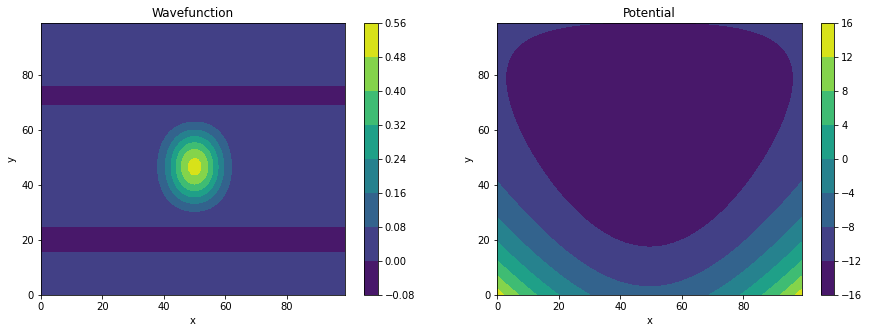

In [ ]:
#@title Example Coupled morse potentials
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

# Excited state for Morse potentials

In this section we are going to generate data following a Hamiltonian with two decoupled morse potentials for a excited state with energy level $(n_x,n_y)$. Then we test the model with the coupled morse potential.

## Generate data

Two strategies were used to generate useful training data:


+ **Selecting the Morse parameters $(D_1,a_1)$, $(D_2,a_2)$:** We selected the parameters of the decoupled potential in two different ways:

    + By performing curve fitting and finding the parameters $(D_1,a_1)$, $(D_2,a_2)$ which best approximate the coupled morse potential.

    +  By choosing the parameters $(D_1,a_1)$, $(D_2,a_2)$ which have the same quadratic order Taylor expansion coefficients as the coupled Morse potential. The choice should be

\begin{equation}
\left\{
\begin{array}{l}
D_1 = D_e \\
D_2 = De\\
a_1 = \sqrt{G_{11} - G_{12}}a\\
a_2 = \sqrt{G_{11} + G_{12}}a\
\end{array} 
\right.
\end{equation}


In order to obtain the traing data we first generated samples of the parameters of the coupled Morse potential $a\in [0.09, 0.12]$, $D_e \in [1,10]$ and then found the decoupled Morse $(D_1,a_1)$, $(D_2,a_2)$ parameters according to the previous strategies.  For higher energy states, another are also needed, which will be introduced later.




In [225]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:
  '''
  Class to generate potentials and wavefunctions of decoupled Morse potentials.
  Attributes:
    a_min (float): minimum value of Morse parameter a
    a_max (float): maximum value of Morse parameter a
    m (float): Mass
    xe_min (float): minimum value of Morse parameter xe
    xe_max (float): maximum value of Morse parameter xe
    hbar (float): h bar
    De_min (float): minimum value of Morse parameter De
    De_max (float): maximum value of Morse parameter De
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    ymin (int): minimum value of y
    ymax (int): maximum value of y
    n_points (int): number of points of the domain
    a_x (np.array): Values of Morse parameters a (x direction)
    a_y (np.array): Values of Morse parameters a (y direction)
    xe (np.array): Values of Morse parameters xe 
    ye (np.array): Values of Morse parameters ye
    De_x (np.array): Values of Morse parameters De (x direction)
    De_y (np.array): Values of Morse parameters De (y direction)
  '''

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    '''
    Generate Morse parameters a, xe, De for x and y axis
    Args:
      N (int): number of samples
    '''
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      Dex (float): De in the x direction
      Dey (float): De in the y direction
      ax (float): a in the x direction
      ay (float): a in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
      xe (np.array): Values of xe foe every sample
    Returns:
      phi_n (np.array): eigenfunctions
      potential (np.array): V(x,y)
      x (np.array): x grid
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)

    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    pot = z**(lamb -n -1/2) # Potential term

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    phi_n = pot*exp*laguerre
    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    Args:
      N (int): size of HO basis
      n (int): energetic level
      new_a (boolean): If true, new Morse parameters are generated 
      nx (int): quantum number in x axis
      ny (int): quantum number in y axis
    Returns:
      phi (np.array): Wavefunctions
      x (np.array): x grid
      y (np.array): y grid
      a_x (np.array): Values of a in x axis
      a_y (np.array): Values of a in y axis
      De_x (np.array): Values of De in x axis
      De_y (np.array): Values of De in y axis
      xe (np.array): Values of xe
      ye (np.array): Values of ye
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
  
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys


  def get_energy(self, n,nx = None, ny=None, a_x = None,
                 De_x = None, a_y = None, De_y = None):
    '''
    Returns analytical energy.
    Args:
      n (int): Energetic level
      nx (int): quantum number in x axis
      ny (int): quantum number in y axis
      a_x (np.array): Values of a in x axis
      a_y (np.array): Values of a in y axis
      De_x (np.array): Values of De in x axis
      De_y (np.array): Values of De in y axis
    Returns:
      E (np.array): energy for every sample
    '''
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


def get_min_max(data):
  '''
  Calculates number of maxima and minima of wavefunciton
  Args:
    data (np.array): array containing an eigenfunction
  Returns:
    num_max (int): Number of maxima
    num_min (int): Number of minima
    data (np.array): eigenfunction

  '''
  data_max = maximum_filter(data, 10)
  maxima = (data == data_max)*(data>1e-1)
  num_max = np.sum(maxima)

  data_min = minimum_filter(data, 10)
  minima = (data == data_min)*(data<-1e-1)
  num_min = np.sum(minima)

  if np.where(maxima)[1][0] < np.where(minima)[1][0]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
    return num_min, num_max, -data
  return num_max, num_min, data

def normalize_wave(data):
  '''
  Normalizes the wavefuncion
  Args:
    data (np.array): Eigenfunction
  Returns:
    Normalized eignefunction
  '''
  h = (xmax - xmin)/n_points
  C =1./np.sqrt(np.sum(data*data*h*h))
  return C*data

def find_true_sate(waves, guesses=[6,7,8], true_min=3, true_max=3):
  '''
  Given an array with multiple wavefunctions, returns the wavefunctions
  with nx = 1, ny=2
  Args:
    waves (np.array): Array containing all the eigenfunctions
    guesses (list): Guesses to look for the desired eigenfunction
    true_min (int): number of minima
    true_max (int): number of maxima
  Returns:
    waves_sol (np.array): Array containing the eigenfuctions with nx=1, ny=2
  '''
  n_samples = waves.shape[1]
  waves_sol = np.zeros((n_samples, n_points, n_points))
  for i in range(n_samples):
    for guess in guesses:
      data = waves_tot[guess, i,:,:]
      num_max, num_min, data = get_min_max(data)
      if num_max==true_max and num_min==true_min: 
        waves_sol[i,:,:] = normalize_wave(data)
        break
  print("Error, no state found")
  return waves_sol

In [9]:
#@title Code to generate data to fit a coupled morse potential
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False, n_state=7) 

    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+1.5, y_max=self.ymax+5)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+1.5, y_max=self.ymax+5, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [10]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
fit_morse = fit_coupled_morse()
V1,waves1,x1,y1,pot1 = fit_morse.fit(n_samples)
V2,waves2,x2,y2,pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

 i=3

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=2499

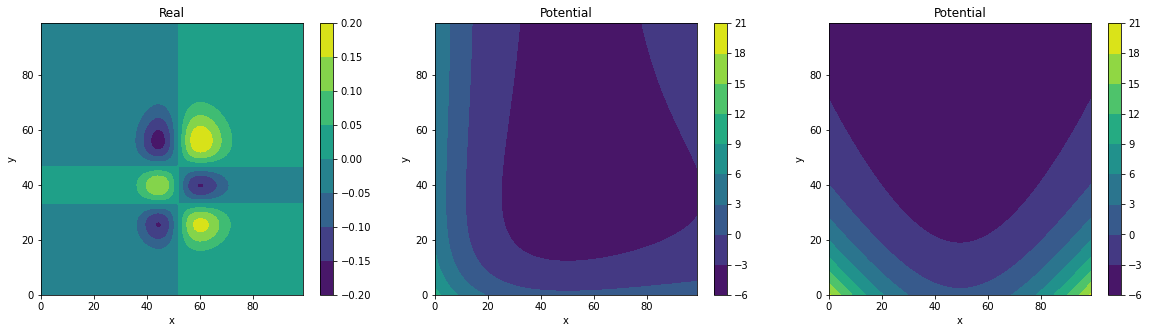

In [13]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

cs3 = ax3.contourf(pot2[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cs1 = ax1.contourf(waves2[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(V1[idx,:,:], levels = cs3.levels)
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")


cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

## Train model

In [14]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [15]:
#@title Class to train the network
#@markdown Double click to see the code
class Training():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))#tf.keras.losses.MeanSquaredError(y_true_reshaped, y_pred)

  def evaluate_loss(self, y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    f = tf.keras.losses.MeanSquaredError()
    l = []
    for i in range(y_true.shape[0]):
      l1 = f(y_true_reshaped[i,:], y_pred[i,:])
      l2 = f(y_true_reshaped[i,:], - y_pred[i,:])
      l.append(np.min([l1,l2]))
    return np.mean(l)

  def loss_val(self, x_val, y_val):
      '''
      Computes the validation loss 
      Args:
        x_val(tensor): batch of validation sample
        y_val (tensor): labels for validation
      Returns:
         val_loss(tensor): validation loss
      '''
      pred_val = self.net(x_val, False)
      val_loss = self.loss( y_val, pred_val)
      return val_loss

  def early_stop(self, epoch, val_loss, stop):
      '''
      Assesses if we have to stop training
      Args:
         epoch (int): current epoch
         val_loss (tensor): current validation loss
         stop (bool): early stop parameter
      Returns:
         stop(bool): True if the models stops training, false if it continues training
      '''
      #Store best validation loss
      if epoch == 0:
          self.best_loss = val_loss
      else:
          if val_loss < self.best_loss:
              self.stopping_step = 0
              self.best_loss = val_loss
          else:
              #If the validation loss does not decrease, we increase the number of stopping steps
              self.stopping_step += 1
      #If such number reaches the maximum, we stop training
      if self.stopping_step == self.early_stopping:
          stop = True
          print('Early stopping was triggered ')
      return stop

    # Optimization process. 
  @tf.function()
  def run_optimization(self,x, y):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
        y (tensor): Labels for training data
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          loss = self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  #@tf.function
  def fit(self, X_train,y_train, X_test,y_test, save=True):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data
      y_train (numpy array): Labels training data
      X_test (numpy array): Processed test data
      y_test (numpy array): Labels test data
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)
    

    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size) 

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters and stop == False:
        for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train)
            loss_batch.append(loss.numpy())

        for (test_x, test_y) in test_data:
            #Compute validation loss
            val_loss = self.loss_val(test_x, test_y)
            val_loss_batch.append(val_loss.numpy())
        
        stop = self.early_stop(epoch, val_loss, stop)
        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Validation loss: ", val_loss.numpy(), "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [16]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [17]:
#@title Parameters to tran the neural network { output-height: 10 }
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter the data parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the training parameters:
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n12/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.3#@param {type:"number"}
#@markdown ---



In [18]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./trained_models/coupled_morse/n12/tf_ckpts/ckpt-2


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=300, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Restored from ./Random_potentials/2D/n12/tf_ckpts/ckpt-1
Epoch:  10 Validation loss:  3.085924e-08 Loss:  1.6721056e-07
Epoch:  20 Validation loss:  1.8833481e-06 Loss:  1.1312806e-06
Epoch:  30 Validation loss:  8.4547344e-07 Loss:  3.85406e-07
Epoch:  40 Validation loss:  1.5524627e-07 Loss:  4.828576e-08
Epoch:  50 Validation loss:  1.3237548e-07 Loss:  1.7894801e-07
Epoch:  60 Validation loss:  2.0268862e-07 Loss:  1.2264394e-07
Epoch:  70 Validation loss:  1.1490174e-06 Loss:  4.0881656e-07
Epoch:  80 Validation loss:  3.0031524e-07 Loss:  4.952246e-07
Epoch:  90 Validation loss:  3.0912943e-07 Loss:  8.92805e-08
Epoch:  100 Validation loss:  2.5778544e-08 Loss:  1.1196213e-07
Epoch:  110 Validation loss:  7.482548e-08 Loss:  2.2099134e-07
Early stopping was triggered 
Saved checkpoint for step ./Random_potentials/2D/n12/tf_ckpts/ckpt-2


## Generate test data

In [61]:
#@markdown ---
#@markdown ### Enter the network parameters:
n_samples = 500#@param {type:"integer"}
n_state = 15#@param {type:"integer"}
n_points = 100#@param {type:"integer"}
n0=0#@param {type:"integer"}
xmin=-10#@param {type:"number"}
xmax = 10#@param {type:"number"}

#@markdown ---



morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax, 
                                        y_min = xmin, y_max = xmax, xe_min =0,
              xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 150, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves = find_true_sate(waves_tot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 4/5Error, no state found


In [62]:
#@title Make predictions
pred = conv_model(potential)
print("Test MSE: %f" % train.loss(pred, waves))

Test MSE: 0.000063


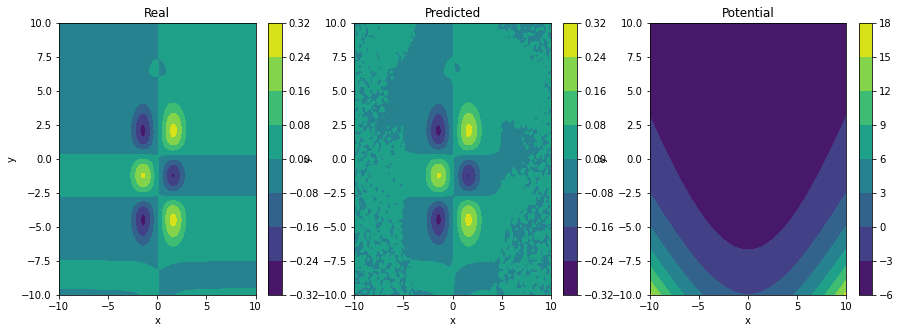

In [74]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx =0
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))

cs1 = ax1.contourf(x,y,waves[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)
h=(xmax-xmin)/n_points
C = 1/np.sqrt(np.sum(pred_reshape[idx,:,:]**2*h*h))
pred_reshape =C*pred_reshape[idx,:,:] 
cs2 = ax2.contourf(x,y,pred_reshape)
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(x,y,potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Eigenstate $n_x$= 0, $n_y=5$

In [76]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real = morse_coupled.find_true_sate(waves_tot,  guesses=[6,7,8], true_min=2, true_max=3)
    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+0.5, y_max=self.ymax+7, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

We look for the parameters of a decoupled morse potential ($D_x$, $a_x$, $D_y$, $a_y$ ) which best approximate the potential of a coupled potential.

In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 10
n_state=50
n0=0

fit_morse = fit_coupled_morse(nx=0, ny=4)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = True)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 9/10Error, no state found
 i=2

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=9

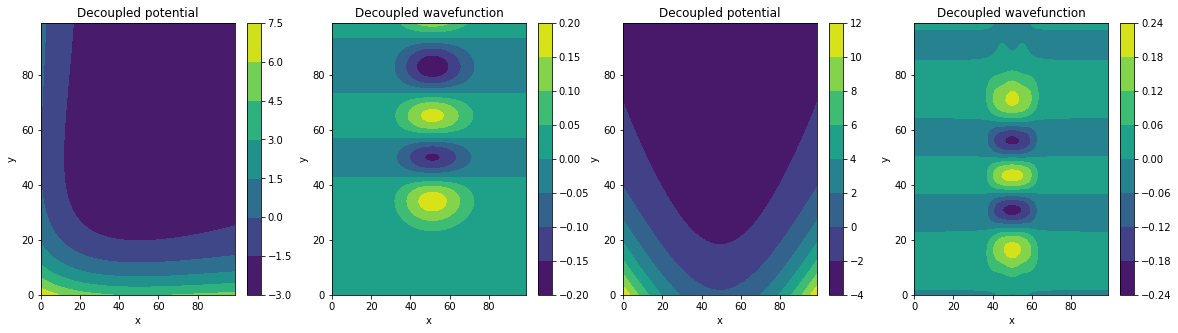

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

cs4 = ax4.contourf(wr[idx,:,:])
ax4.set_title("Decoupled wavefunction")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
fig.colorbar(cs4, ax=ax4)

plt.show()


We see that the wavefunction does not fit our grid. Moreover, the real wavefunction is placed lower in the y direction and it is stretched compared to the decoupled wavefunction. Therefore, we are going to change the values of the x-y grid for the decoupled potential so that the wavefunctions are more similar. This constitutes the second strategy to generate the data:

+ **Selecting the $x$ and $y$ range:** Once the Morse parameters have been chosen we try to improve the resemblance with the coupled Morse potential by changing the values of the spatial domain. The input of the neural network is a grid containing the values of the potential in a certain spatial domain, but such domain is not specifically given. Therefore, if we change the range of this domain the network will not notice the difference, as long as the number of points remains constant. This fact allows us to stretch the spatial domain so that the decoupled potential is more similar to the coupled potential. We performed a grid search to find the domain ranges which best approximated the coupled potential energy. The only constraint is that in a given spatial domain, the associated wave function fits into that domain. Otherwise, the sample will no be useful for training. Recall that this technique could only be used because the learning algorithm (i.e the neural network) is a data-based approach, instead of a model-based approach, which means that uses no information about the underlying physical model of the system. 



In [ ]:
#@title Grid search to find x and y range
#@markdown **Note: This code may take hours to run**
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=0, ny=4)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves = morse_coupled.find_true_sate(waves_tot,  guesses=[6,7,8], true_min=2, true_max=3)                                                                   

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess)


  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = 0
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = 0


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9.5,-9,-8.5,-7,-7.5,-6,-6.5],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  '''
  Class to perform gridsearch to find the best fitting x and y range.
  Attributes:
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    ymin (int): minimum value of y
    ymax (int): maximum value of y
  '''
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    '''
    Given the values of the Morse parameters (in X), predict the wavefunctions
    Args:
      X (np.array): containing the Morse parametes
    Returns:
      eigenfunctions
    '''
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, 
                                                             new_a=False,
                                                             nx=0, ny=4) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
    '''
    Get the x and y grid parameters
    Returns:
      dict containing xmin, xmax, ymin, ymax
    '''
        return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    '''
    Set the parametes xmin, xmax, ymin, ymax
    '''
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 15, 'xmin': -14, 'ymax': 18, 'ymin': -8.5}

In [78]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_state=50
n0=0
x_min_fit = -14 
x_max_fit =15
y_min_fit =-8.5
y_max_fit =18
fit_morse = fit_coupled_morse(nx=0, ny=4)
V1,waves1,x1, y2, pot1,_ = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)


idx=-1

 i=3

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=2499

In [79]:
#@title Parameters to tran the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n05/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 128#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=64#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 256#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



In [80]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=100, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  3.1550405e-06 Loss:  3.657158e-06
Epoch:  20 Validation loss:  4.7197755e-06 Loss:  2.6398957e-06
Epoch:  30 Validation loss:  1.3901322e-06 Loss:  2.1526703e-06
Epoch:  40 Validation loss:  7.6491466e-07 Loss:  1.3467329e-06
Epoch:  50 Validation loss:  7.0114737e-07 Loss:  1.9292713e-06
Epoch:  60 Validation loss:  4.0083856e-07 Loss:  2.684782e-07
Epoch:  70 Validation loss:  6.125614e-05 Loss:  6.5539774e-05
Epoch:  80 Validation loss:  6.131501e-05 Loss:  3.7817298e-07
Epoch:  90 Validation loss:  1.1567571e-06 Loss:  2.4083968e-07
Epoch:  100 Validation loss:  7.070575e-06 Loss:  7.511852e-07
Epoch:  110 Validation loss:  1.1482746e-06 Loss:  8.5721535e-07
Epoch:  120 Validation loss:  5.9924855e-07 Loss:  1.2816736e-06
Epoch:  130 Validation loss:  1.3496214e-06 Loss:  5.794957e-07
Epoch:  140 Validation loss:  1.7468913e-06 Loss:  1.026277e-06
Epoch:  150 Validation loss:  3.447141e-07 Loss:  2.0925683e-07
Epoch:  160 Validation loss:  6.979111e-07 

## Generate test data

In [103]:
#@title Code to generate Coupled Morse Potentials for nx=0, ny=4
#@markdown Double click to see the code

def get_min_max(data):
  '''
  Calculates number of maxima and minima of wavefunciton
  Args:
    data (np.array): array containing an eigenfunction
  Returns:
    num_max (int): Number of maxima
    num_min (int): Number of minima
    data (np.array): eigenfunction

  '''
  data_max = maximum_filter(data, 10)
  maxima = (data == data_max)*(data>1e-1)
  num_max = np.sum(maxima)

  data_min = minimum_filter(data, 10)
  minima = (data == data_min)*(data<-1e-1)
  num_min = np.sum(minima)

  if np.where(maxima)[0][0] > np.where(minima)[0][0]:
    return num_min, num_max, -data
  return num_max, num_min, data

def normalize_wave(data):
  '''
  Normalizes the wavefuncion
  Args:
    data (np.array): Eigenfunction
  Returns:
    Normalized eignefunction
  '''
  h = (xmax - xmin)/n_points
  C =1./np.sqrt(np.sum(data*data*h*h))
  return C*data

def find_true_sate(waves, guesses=[6,7,8], true_min=2, true_max=3):
  '''
  Given an array with multiple wavefunctions, returns the wavefunctions
  with nx = 0, ny=4
  Args:
    waves (np.array): Array containing all the eigenfunctions
    guesses (list): Guesses to look for the desired eigenfunction
    true_min (int): number of minima
    true_max (int): number of maxima
  Returns:
    waves_sol (np.array): Array containing the eigenfuctions with nx=0, ny=4
  '''
  n_samples = waves.shape[1]
  waves_sol = np.zeros((n_samples, n_points, n_points))
  for i in range(n_samples):
    for guess in guesses:
      data = waves_tot[guess, i,:,:]
      num_max, num_min, data= get_min_max(data)
      if num_max==true_max and num_min==true_min: 
        waves_sol[i,:,:] = normalize_wave(data)
        break
  return waves_sol

In [104]:
# Generate data
n_samples = 500
n_state = 50
n_points = 100
n0=0
xmin=-10
xmax = 10
G11 = 1.05472
G12 = 0.01559

morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax,
                                        y_min = xmin, y_max=xmax, xe_min =-0.05,
                                        xe_max = 0.05, a_min = 0.09, a_max = 0.1,
                                        De_max = 3, De_min =1)

x, y, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves_real = find_true_sate(waves_tot)

idx = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 4/5

In [105]:
#@title Make predictions
pred = conv_model(potential)
print("Test MSE: %f" % train.loss(pred, waves_real))
idx=-1

Test MSE: 0.000001


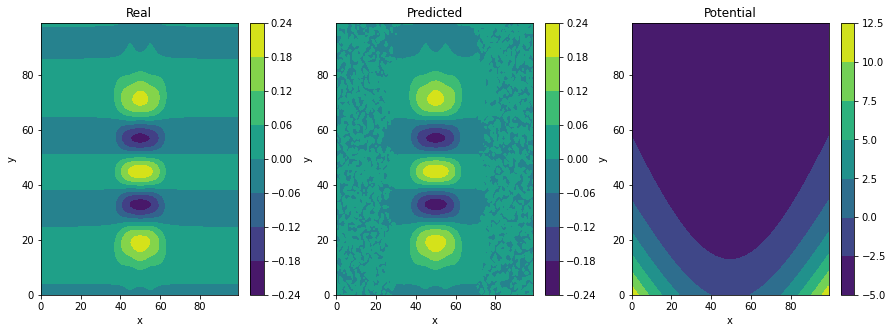

In [106]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)

cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Eigenstate $n_x$= 1, $n_y=1$

In [139]:
#@title Code to generate Coupled Morse Potentials nx=1, ny=1
#@markdown Double click to see the code

def get_min_max(data, tol=2):
  '''
  Calculates number of maxima and minima of wavefunciton
  Args:
    data (np.array): array containing an eigenfunction
  Returns:
    num_max (int): Number of maxima
    num_min (int): Number of minima
    data (np.array): eigenfunction

  '''
  data_max = maximum_filter(data, 10)
  maxima = (data == data_max)*(data>1e-1)
  num_max = np.sum(maxima)

  data_min = minimum_filter(data, 10)
  minima = (data == data_min)*(data<-1e-1)
  num_min = np.sum(minima)
  side = np.abs(np.where(maxima)[0][0] - np.where(minima)[0][0])<tol

  if np.where(maxima)[1][0] > np.where(minima)[1][0]:
    return num_min, num_max, -data, side
  return num_max, num_min, data, side

def normalize_wave(data):
  '''
  Normalizes the wavefuncion
  Args:
    data (np.array): Eigenfunction
  Returns:
    Normalized eignefunction
  '''
  h = (xmax - xmin)/n_points
  C =1./np.sqrt(np.sum(data*data*h*h))
  return C*data

def find_true_sate(waves, guesses=[6,7,8], true_min=3, true_max=3):
  '''
  Given an array with multiple wavefunctions, returns the wavefunctions
  with nx = 0, ny=4
  Args:
    waves (np.array): Array containing all the eigenfunctions
    guesses (list): Guesses to look for the desired eigenfunction
    true_min (int): number of minima
    true_max (int): number of maxima
  Returns:
    waves_sol (np.array): Array containing the eigenfuctions with nx=0, ny=4
  '''
  n_samples = waves.shape[1]
  waves_sol = np.zeros((n_samples, n_points, n_points))
  for i in range(n_samples):
    for guess in guesses:
      data = waves_tot[guess, i,:,:]
      num_max, num_min, data, side = get_min_max(data)
      if num_max==true_max and num_min==true_min and side:
        waves_sol[i,:,:] = normalize_wave(data)
        break
  return waves_sol

In [ ]:
#@title Get the best x and y range 
#@markdown Double click to see the code
#@markdown **Note: this code may take hours to run**
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=0, ny=4)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves = morse_coupled.find_true_sate(waves_tot,  guesses=[4,5], true_min=2, true_max=2)                                                                 

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess)


  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = 0
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = 0


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9.5,-9,-8.5,-7,-7.5,-6,-6.5],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  '''
  Class to perform gridsearch to find the best fitting x and y range.
  Attributes:
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    ymin (int): minimum value of y
    ymax (int): maximum value of y
  '''
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    '''
    Given the values of the Morse parameters (in X), predict the wavefunctions
    Args:
      X (np.array): containing the Morse parametes
    Returns:
      eigenfunctions
    '''
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, new_a=False,
                                                             nx=1, ny=1) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
    '''
    Get the x and y grid parameters
    Returns:
      dict containing xmin, xmax, ymin, ymax
    '''
    return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    '''
    Set the parametes xmin, xmax, ymin, ymax
    '''
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 10, 'xmin': -17, 'ymax': 18, 'ymin': -10}

In [108]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False, n_state=6) 
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = -12, x_max=12,
                    y_min =-10, y_max=15)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+0.5, y_max=self.ymax+7, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [109]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
fit_morse = fit_coupled_morse(nx=1, ny=1)
V1,waves1,x1, y2, pot1 = fit_morse.fit(n_samples)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

 i=3

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=2499

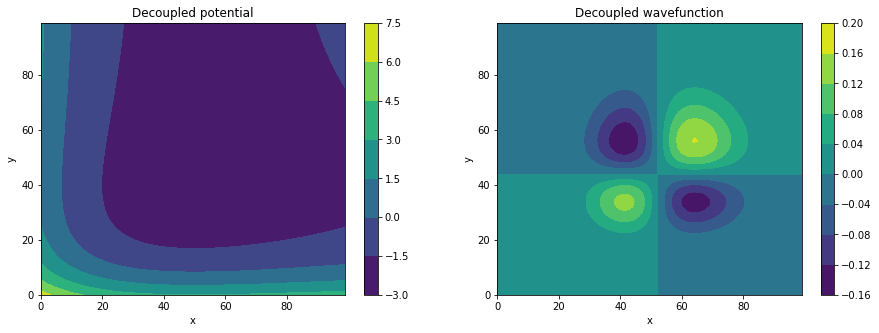

In [110]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [111]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n11/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 128#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=64#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 256#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



In [112]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=50, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  1.179866e-06 Loss:  1.5079148e-06
Epoch:  20 Validation loss:  7.123326e-07 Loss:  1.5480778e-06
Epoch:  30 Validation loss:  4.8772836e-07 Loss:  3.2584651e-07
Epoch:  40 Validation loss:  2.403845e-07 Loss:  2.2100119e-07
Epoch:  50 Validation loss:  8.866312e-08 Loss:  1.9216085e-07
Epoch:  60 Validation loss:  8.526055e-08 Loss:  7.991695e-08
Epoch:  70 Validation loss:  9.185866e-08 Loss:  9.925963e-08
Epoch:  80 Validation loss:  7.732369e-08 Loss:  1.6909075e-07
Epoch:  90 Validation loss:  8.124215e-08 Loss:  6.814467e-08
Epoch:  100 Validation loss:  1.8220238e-08 Loss:  1.9687224e-08
Epoch:  110 Validation loss:  3.2883072e-08 Loss:  2.6904928e-08
Epoch:  120 Validation loss:  2.0029653e-08 Loss:  2.1236415e-08
Epoch:  130 Validation loss:  2.5214211e-08 Loss:  2.2013383e-08
Epoch:  140 Validation loss:  3.176625e-07 Loss:  1.3984496e-07
Epoch:  150 Validation loss:  1.2337804e-07 Loss:  2.6203704e-08
Epoch:  160 Validation loss:  1.0498603e-08 Lo

## Generate test data

In [140]:
# Generate data
n_samples = 5
n_state = 50
n_points = 100
n0=0
xmin=-10
xmax = 10
G11 = 1.05472
G12 = 0.01559

morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax,
                                        y_min = xmin, y_max=xmax, xe_min =-0.05,
                                        xe_max = 0.05, a_min = 0.09, a_max = 0.1,
                                        De_max = 3, De_min =1)

x, y, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves_real = find_true_sate(waves_tot,  guesses=[4,5], true_min=2, true_max=2)

idx = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 4/5

In [141]:
#@title Make predictions
pred = conv_model(potential)
print("Test MSE: %f" % train.loss(pred, waves_real))
idx=-1

Test MSE: 0.000000


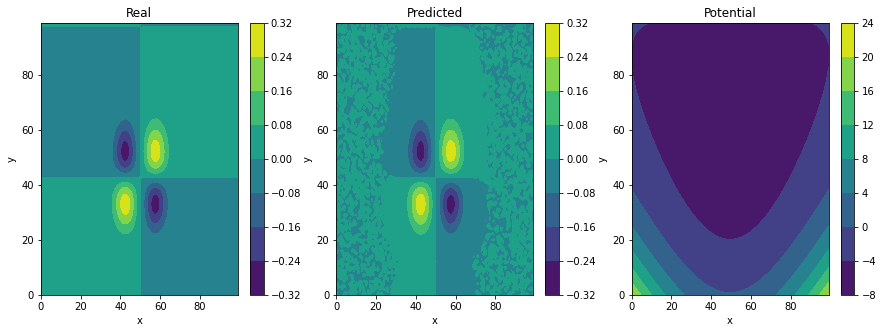

In [142]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)

cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

## Eignestate $n_x=2$, $n_y=6$

In this section we are going to deal with anomalous states, that is, states where the atomic numbers are not well defined.

In [ ]:
#@title Code to generate Coupled Morse Potentials nx=2, ny=6
#@markdown Double click to see the code

def get_min_max(data):
    '''
    Calculates number of maxima and minima of wavefunciton
    Args:
      data (np.array): array containing an eigenfunction
    Returns:
      num_max (int): Number of maxima
      num_min (int): Number of minima
      data (np.array): eigenfunction

    '''
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)

    if np.where(maxima)[1][1] > np.where(minima)[1][1]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
        return num_min, num_max, -data
    return num_max, num_min, data

def normalize_wave(data):
    '''
    Normalizes the wavefuncion
    Args:
      data (np.array): Eigenfunction
    Returns:
      Normalized eignefunction
    '''
    h = (xmax - xmin)/n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

def find_true_sate(waves, guesses=[28,29], true_min=11, true_max=10, tol=4):
    '''
    Given an array with multiple wavefunctions, returns the wavefunctions
    with nx = 0, ny=4
    Args:
      waves (np.array): Array containing all the eigenfunctions
      guesses (list): Guesses to look for the desired eigenfunction
      true_min (int): number of minima
      true_max (int): number of maxima
    Returns:
      waves_sol (np.array): Array containing the eigenfuctions with nx=0, ny=4
    '''
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, n_points, n_points))
    err = np.zeros(len(guesses))
    error = []
    for i in range(n_samples):
        datas = []
        for j in range(len(guesses)):
            data = waves[guesses[j], i,:,:]
            num_max, num_min, true_data  = get_min_max(data)
            datas.append(true_data)
            err[j] = abs(num_max-true_max) + abs(num_min-true_min)
                
        argmin_err = np.argmin(err)
        if err[argmin_err]<=tol:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
        else:
            print("Error, no state found. i: ",  i)
            error.append(i)
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
    return waves_sol, err
  

In [ ]:
#@title Get the best x and y range { form-width: "20%" }
#@markdown Double click to see the code
#@markdown **Note: This cell may take hours to run**
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=2, ny=6)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 250, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves,_ = find_true_sate(waves_tot, guesses=[28,29], true_min=11, true_max=10, tol=4)                                                         

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  bounds=((0.3, 0, -np.inf, 0.3, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.12, 5))
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = popt[2]
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = popt[5]


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9,-8,-7,-7.5,-6.5,-5,-4.5, -4, -3.5, -3],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  '''
  Class to perform gridsearch to find the best fitting x and y range.
  Attributes:
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    ymin (int): minimum value of y
    ymax (int): maximum value of y
  '''
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    '''
    Given the values of the Morse parameters (in X), predict the wavefunctions
    Args:
      X (np.array): containing the Morse parametes
    Returns:
      eigenfunctions
    '''
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, new_a=False,
                                                             nx=2, ny=6) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
    '''
    Get the x and y grid parameters
    Returns:
      dict containing xmin, xmax, ymin, ymax
    '''
    return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    '''
    Set the parametes xmin, xmax, ymin, ymax
    '''
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 14, 'xmin': -17, 'ymax': 17, 'ymin': -10}

In [144]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real,_ = find_true_sate(waves_tot, guesses=[28,29], true_min=11, true_max=10, tol=4)
    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0, -np.inf, 0.3, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.12, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [145]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -18
x_max_fit =11
y_min_fit =-5
y_max_fit =18
fit_morse = fit_coupled_morse(nx=2, ny=6, xmin=-15, xmax = 15, ymin=-7, ymax = 18)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

x_min_fit = -20
x_max_fit =22
y_min_fit =-8
y_max_fit =17

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

 i=2499

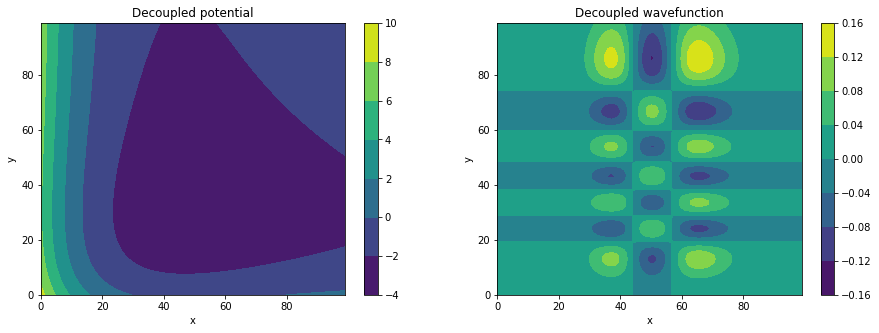

In [146]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [147]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n26/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [148]:
#@title Load data
# Load data
with open("./training_data/coupled_morse/V_coupled26.npy", 'rb') as f:
  V_real = np.load(f)
with open("./training_data/coupled_morse/waves_coupled26.npy", 'rb') as f:
  waves_real = np.load(f)



## Training a neural network with Schrodinger loss

When the energy of the system increases, the eigenfunction of the Coupled morse Hamiltonian shows significant differences with respect to any of the eigenfunctions of the decoupled morse Hamiltonian. For example, the number of nodes of the wavefunction is not well-defined. In this case, training the neural network with only the decoupled wavefunction does not give optimal results. For this reason, we add a custom loss function to help training the neural network. 

Here we introduce the Scrhödinger loss function, which ensures that the wavefunction is an eigenstate of the Hamiltonian.

\begin{equation}
S_{loss} = ||H\hat{\psi} - \hat{E}\hat{\psi}||^2 + \lambda_{norm}||\hat{\psi}||^2
\end{equation}

Where $\hat{E}$ is the predicted mean energy, which is calculated using the input potential and the predicted wavefunction $\hat{\psi}$. Therefore the total loss function is:

\begin{equation}
\mathcal{L} =  MSE_d + \lambda \bar{S}_{loss_c} =  \frac{1}{N_d} \sum_{i=0}^{N_d} ||\hat{\psi^d}_i - \psi_i^d||^2 + \lambda \Big(||H\hat{\psi^c} - \hat{E}\hat{\psi^c}||^2 + \lambda_{norm}||\hat{\psi^c}||\Big)
\end{equation}

Where $\{\psi_i^d\}_i$ are the wavefunctions of the decoupled Hamiltonian and $\{\psi_i^c\}_i$ are the wavefunctions of the coupled Hamiltonian, and $\lambda, \lambda_{norm} \in \mathbb{R}$. $\lambda_{norm}$ is chosen so that the two terms of the Schr\"{o}dinger loss have the same order of magnitude. In this case, we choose $\lambda_{norm}=10^4$ for all the training process. We train the network for 300 iterations. During the first 100 iterations we set $\lambda=0$ so that the model learns to reproduce the wavefunctions of multiple decoupled Hamiltonians. Then, we choose $\lambda$ so that the two loss functions have the same order of magnitude. In this case, we set $\lambda=10^{5}$. Notice that since the decoupled morse potential already gives a fair approximation of the true wavefunction, we do not need to put any constraints on the energy of the system. The neural network converges to the true solution, which follows the Scrh\"{o}dinger equation.  





In [149]:
#@title Class to train the network { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    '''
    Calculates MSE
    Args:
      y_true (tensor): True values of the wavefunction
      y_pred (tensor): Predicted values of the wavefunction
    Returns:
      MSE (tensor)
    '''
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,
                       xmin=-10, xmax=10, 
                       ymin=-10, ymax=10, lamb_norm=1e3):
    '''
    Schrodinger loss
    Args:
      phi (tensor): wavefunction
      potential (tensor): Potential V(x,y)
      xmin (int): minimum value of x
      xmax (int): maximum value of x
      ymin (int): minimum value of y
      ymax (int): maximum value of y
      lamb_norm (float): Lambda parameter for norm loss
    Returns:
      schrodinger loss
      norm loss
    '''
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    phir = tf.concat([phi[:,:,1:,:], tf.zeros((phi.shape[0],phi.shape[1],1,1))], axis=2)
    phil = tf.concat( [tf.zeros((phi.shape[0],phi.shape[1],1,1)), phi[:,:,:-1,:]], axis=2)

    dxx = (phir - 2*phi + phil)/(h1*h2) 

    phir = tf.concat([ phi[:,1:,:,:], tf.zeros((phi.shape[0],1,phi.shape[1],1))], axis=1) # We add 0 at the extrema. It makes sense because phi(x)->0 at x->+-inf
    phil = tf.concat([ tf.zeros((phi.shape[0],1,phi.shape[1],1)), phi[:,:-1,:,:]], axis=1)

    dyy = (phir - 2*phi + phil)/(h1*h2) 

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,phi)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(phi,H_phi), axis = [1,2,3])
    E = tf.reshape(energy, (-1,1,1,1))

    #Calculate norm
    norm = tf.reduce_sum(tf.square(phi)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - E*phi), axis=[1,2,3])

    return tf.reduce_mean(mse), tf.reduce_mean(tf.square(norm-1))

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5, lamb_norm=1e4):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of decoupled training potential
        y (tensor): Samples of decoupled training wavefunction
        x_coup (tensor): Samples of coupled training potential
        dec (boolean): If true, the schrodinger loss is used
        lamb (float): Lambda parameter
        lab_norm (float): Lamb_norm parameter
      Returns:
        loss (tensor): Total loss
        s_loss (tensor): Schrodinger loss
        dec_loss (tensor): MSE for decoupled data
        norm_loss (tensor): norm loss
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
            s_loss = None
            norm_loss = None
            dec_loss=loss
          else:
            pred_coup = self.net(x_coup)
            s_loss, norm_loss = self.schrodinger_loss(pred_coup, x_coup)
            dec_loss = self.loss(y, pred)
            loss = s_loss + lamb_norm*norm_loss + lamb*dec_loss
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss, s_loss, dec_loss, norm_loss

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, epochs_coup = 100, xmin=-10, xmax=10, lamb=1e5):
    '''
    Main fit function 

    Args:
      X_train_coup (numpy array): Processed training data (coupled Morse potential)
      X_train_dec (numpy array): Processed training data (decoupled Morse potential)
      y_train_dec (numpy array): Processed training labels (decoupled Morse wavefunctions)
      save (bool): If true, we save the weights at the end of the training
      epochs_coup (int): Number of epochs to train only with decoupled Morse potentials
      xmin (int): minimum value of x and y
      xmax (int): maximum value of x and y
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec,X_train_coup))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters:
        for step, (batch_x_train, batch_y_train, _) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        
        if epoch>epochs_coup:
          for step, (batch_x_train, batch_y_train, batch_x_coup) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= batch_x_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())
         #Display the result
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy(), 
                  'Scrhodinger loss: ', s_loss.numpy(), 'Decoupled loss: ', dec_loss.numpy(), 
                  'Norm loss: ', norm_loss.numpy())
        else:
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy())

        epoch += 1

           
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [150]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [151]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train2 = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./trained_models/coupled_morse/n26/tf_ckpts/ckpt-3


In [ ]:
#@title Run to train the model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 300, batch_size, display_step,
                 filepath=filepath, restore=True)
train2.fit(V_real, V_train, waves_train, save=False, lamb=5e5)

In [152]:
#@title Make predictions
pred = conv_model(V_real)
print("Test MSE: %f" % train2.loss(pred, waves_real))
idx=-1

Test MSE: 0.000087


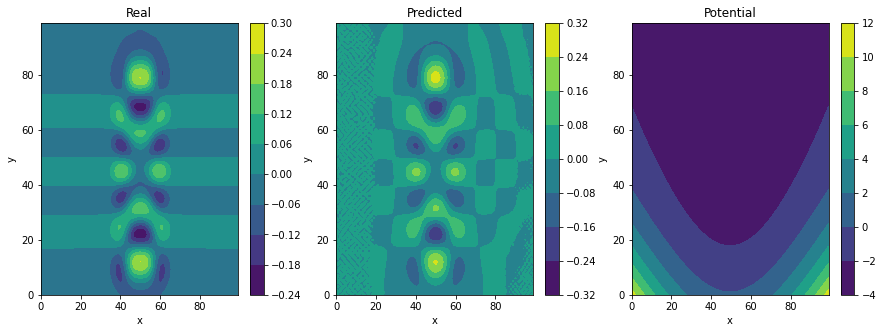

In [188]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx =5
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)


cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Eigenstate n_x=2, ny_=3

In [190]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [191]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -25
x_max_fit =19
y_min_fit =-4
y_max_fit =15
fit_morse = fit_coupled_morse(nx=3, ny=2, xmin=-18, xmax = 18, ymin=-5, ymax = 15)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
x_min_fit = -20
x_max_fit =23
y_min_fit =-7
y_max_fit =14

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

 i=2499

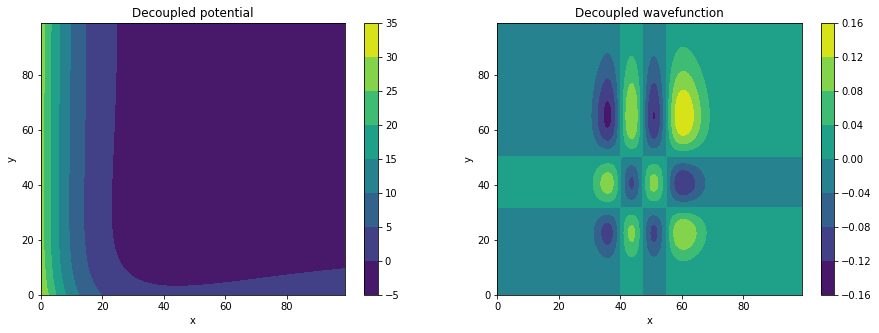

In [192]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [193]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n23/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [194]:
#@title Load data
# Load data
with open("./training_data/coupled_morse/V_coupled23.npy", 'rb') as f:
  V_real = np.load(f)
with open("./training_data/coupled_morse/waves_coupled23.npy", 'rb') as f:
  waves_real = np.load(f)



In [195]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 300, batch_size, display_step,
                 filepath=filepath, restore=True)
train2.fit(V_real, V_train, waves_train, save=True, lamb=5e5)

Initializing from scratch.
Epoch:  1 Loss:  0.0002234955
Epoch:  2 Loss:  6.357545e-05
Epoch:  3 Loss:  0.0002112743
Epoch:  4 Loss:  0.00012423337
Epoch:  5 Loss:  0.00020079856
Epoch:  6 Loss:  7.0434224e-05
Epoch:  7 Loss:  7.418515e-05
Epoch:  8 Loss:  0.00016483536
Epoch:  9 Loss:  0.000100575555
Epoch:  10 Loss:  6.5161235e-05
Epoch:  11 Loss:  7.873708e-05
Epoch:  12 Loss:  1.0541979e-05
Epoch:  13 Loss:  2.8904935e-05
Epoch:  14 Loss:  0.00017722932
Epoch:  15 Loss:  9.569838e-05
Epoch:  16 Loss:  2.4969018e-05
Epoch:  17 Loss:  1.9001987e-05
Epoch:  18 Loss:  0.00011956161
Epoch:  19 Loss:  8.1914495e-06
Epoch:  20 Loss:  0.00010523243
Epoch:  21 Loss:  6.2419545e-05
Epoch:  22 Loss:  1.9062145e-05
Epoch:  23 Loss:  5.802671e-05
Epoch:  24 Loss:  5.825186e-06
Epoch:  25 Loss:  0.00013476529
Epoch:  26 Loss:  6.0667033e-05
Epoch:  27 Loss:  1.7831777e-05
Epoch:  28 Loss:  0.00011397165
Epoch:  29 Loss:  1.8655028e-05
Epoch:  30 Loss:  7.898698e-05
Epoch:  31 Loss:  0.0001310347

In [197]:
#@title Make predictions
pred = conv_model(V_real)
print("Test MSE: %f" % train2.loss(pred, waves_real))
idx=-1

Test MSE: 0.001243


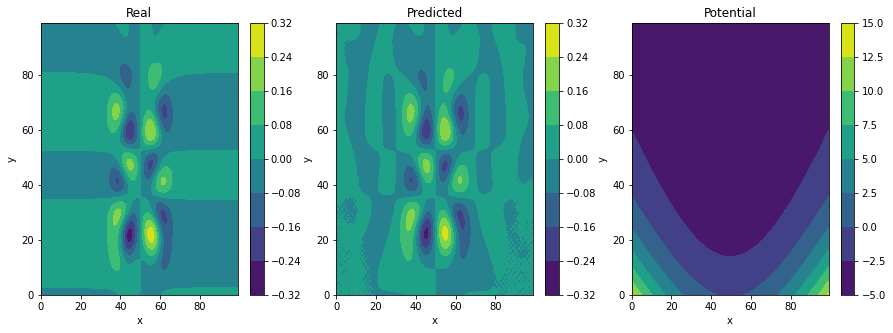

In [202]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)


cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Eigenstate n_x=17, n_y=1

In [203]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials


    G11 = 1.05472
    G12 = 0.35 #0.01559

    morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = self.xmin, x_max=self.xmax, y_min = self.ymin, y_max= self.ymax,
                                            xe_min =-0.01, xe_max = 0.01, a_min = 0.09, a_max = 0.10, 
                                            De_max = 9, De_min =7, G12 = G12, G11 = G11)

    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.11, a_max = 0.12, De_max = 8, De_min =7, G12 = self.G12, G11 = self.G11)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [204]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =14
fit_morse = fit_coupled_morse(nx=13, ny=1, xmin=-8, xmax = 8, ymin=-8, ymax = 8, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
x_min_fit = -8
x_max_fit =16
y_min_fit =-10
y_max_fit =12

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)


idx=-1

 i=2499

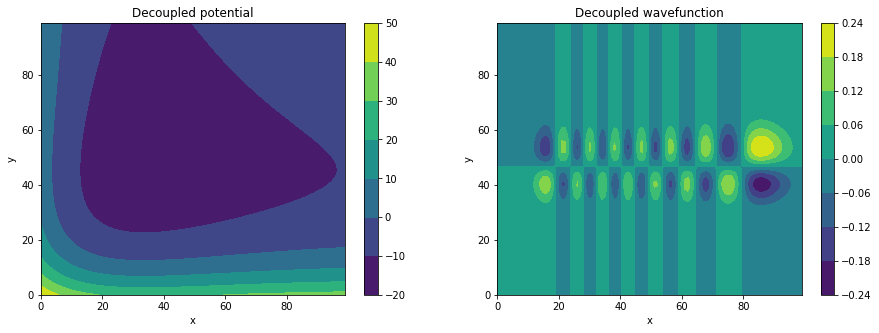

In [205]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V2[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves2[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [206]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n171/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [207]:
#@title Load data
# Load data
with open("./training_data/coupled_morse/V_coupled171.npy", 'rb') as f:
  V_real = np.load(f)
with open("./training_data/coupled_morse/waves_coupled171.npy", 'rb') as f:
  waves_real = np.load(f)



In [208]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 400, batch_size, display_step,
                 filepath=filepath, restore=False)
train2.fit(V_real, V_train, waves_train, save=False, lamb=5e6)

Epoch:  0 Loss:  0.00010744721
Epoch:  1 Loss:  8.625745e-05
Epoch:  2 Loss:  1.5682397e-05
Epoch:  3 Loss:  6.657578e-06
Epoch:  4 Loss:  3.572753e-06
Epoch:  5 Loss:  3.4395953e-06
Epoch:  6 Loss:  4.662329e-06
Epoch:  7 Loss:  3.4613238e-06
Epoch:  8 Loss:  1.821037e-06
Epoch:  9 Loss:  3.9800684e-06
Epoch:  10 Loss:  1.4417078e-06
Epoch:  11 Loss:  1.4009411e-06
Epoch:  12 Loss:  2.5012562e-06
Epoch:  13 Loss:  8.605355e-07
Epoch:  14 Loss:  1.4355613e-06
Epoch:  15 Loss:  1.3944502e-06
Epoch:  16 Loss:  8.6422654e-07
Epoch:  17 Loss:  3.3557315e-06
Epoch:  18 Loss:  1.4036004e-06
Epoch:  19 Loss:  1.4641398e-06
Epoch:  20 Loss:  3.939178e-07
Epoch:  21 Loss:  1.3434917e-06
Epoch:  22 Loss:  5.4759613e-07
Epoch:  23 Loss:  8.2028686e-07
Epoch:  24 Loss:  1.518504e-06
Epoch:  25 Loss:  5.2184606e-07
Epoch:  26 Loss:  7.543166e-06
Epoch:  27 Loss:  5.87241e-07
Epoch:  28 Loss:  5.439404e-07
Epoch:  29 Loss:  1.0827973e-06
Epoch:  30 Loss:  4.5653331e-07
Epoch:  31 Loss:  9.807696e-07

In [213]:
#@title Make predictions
pred = conv_model(V_real)
pred = pred.numpy().reshape(-1,100,100)
idx=-1

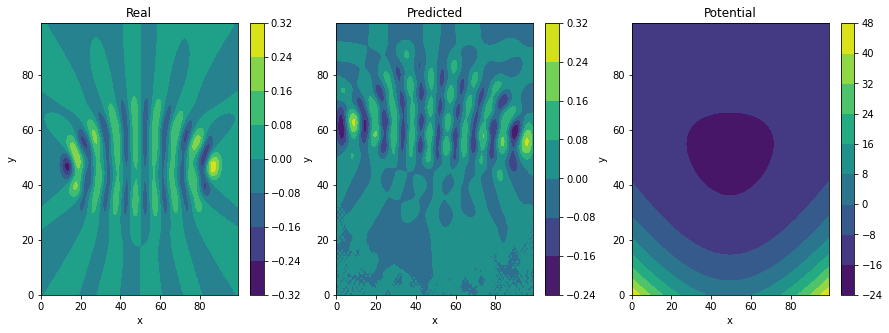

In [214]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Eigenstate n_x = 10, n_y = 10

In [215]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    G11 = 1.05472
    G12 = 0.35

    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 9, De_min =7, G12 = G12, G11 = G11)

    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    G11 = 1.05472
    G12 = 0.35

    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 9, De_min =7, G12 = G12, G11 = G11)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [216]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0
G11 = 1.05472
G12 = 0.25 #0.01559

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =20
fit_morse = fit_coupled_morse(nx=10, ny=10, xmin=-10, xmax = 10, ymin=-10, ymax = 10, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

x_min_fit = -10
x_max_fit =16
y_min_fit =-9
y_max_fit =17

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

idx=-1

 i=2499

In [217]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./trained_models/coupled_morse/n1010/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [220]:
#@title Load data
# Load data
with open("./training_data/coupled_morse/V_coupled1010.npy", 'rb') as f:
  V_real = np.load(f)
with open("./training_data/coupled_morse/waves_coupled1010.npy", 'rb') as f:
  waves_real = np.load(f)



In [221]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 400, batch_size, display_step,
                 filepath=filepath, restore=False)
train2.fit(V_real, V_train, waves_train, save=True, lamb=5e6)

Epoch:  0 Loss:  0.00016642494
Epoch:  1 Loss:  4.2002357e-05
Epoch:  2 Loss:  1.2157444e-05
Epoch:  3 Loss:  8.696592e-06
Epoch:  4 Loss:  8.063842e-06
Epoch:  5 Loss:  1.6112015e-05
Epoch:  6 Loss:  6.506647e-06
Epoch:  7 Loss:  1.079769e-05
Epoch:  8 Loss:  5.5334835e-06
Epoch:  9 Loss:  5.1674438e-06
Epoch:  10 Loss:  6.0272446e-06
Epoch:  11 Loss:  5.88006e-06
Epoch:  12 Loss:  5.4778693e-06
Epoch:  13 Loss:  5.3737413e-06
Epoch:  14 Loss:  2.6354164e-06
Epoch:  15 Loss:  4.8677334e-06
Epoch:  16 Loss:  2.8340846e-06
Epoch:  17 Loss:  3.975432e-06
Epoch:  18 Loss:  3.3051406e-06
Epoch:  19 Loss:  2.122115e-06
Epoch:  20 Loss:  2.7880524e-06
Epoch:  21 Loss:  2.206381e-06
Epoch:  22 Loss:  3.0927172e-06
Epoch:  23 Loss:  1.6928155e-06
Epoch:  24 Loss:  1.2543354e-06
Epoch:  25 Loss:  3.3776375e-06
Epoch:  26 Loss:  1.834143e-06
Epoch:  27 Loss:  1.9721415e-06
Epoch:  28 Loss:  1.5890265e-06
Epoch:  29 Loss:  8.994767e-07
Epoch:  30 Loss:  1.1453957e-06
Epoch:  31 Loss:  3.93345e-06

In [223]:
#@title Make predictions
pred = conv_model(V_real)
pred = pred.numpy().reshape(-1,100,100)
idx=-1

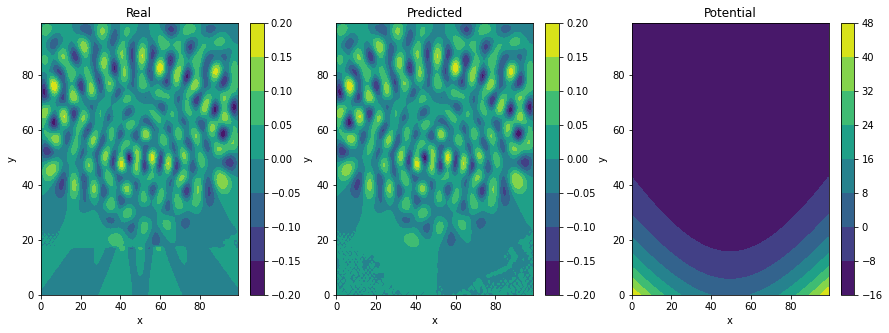

In [224]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()